In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
import copy

from flair.data import Sentence
from flair.nn import Classifier
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings
tagger = Classifier.load('sentiment-fast')
glove_embeddings = WordEmbeddings('glove')
document_embeddings = DocumentPoolEmbeddings([FlairEmbeddings('fi-forward'),
                                              FlairEmbeddings('fi-backward')])

from sklearn.cluster import KMeans

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import TweetTokenizer
nltk.download('vader_lexicon')

from gensim.models import Word2Vec
from gensim.models.fasttext import FastText

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nitanshjain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [90]:
tweets_df = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_cleaned_v2.csv')
print(tweets_df.shape)
tweets_df.head()

(18146, 4)


,tweet_id,tweet,city,year
0,0,it is very bad thing to say that government di...,Mumbai,2022
1,1,all netas and their family should be admitted ...,Mumbai,2022
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022
3,3,till when medical negligence will exist in gov...,Mumbai,2022
4,4,me being a doctor reading this also government...,Mumbai,2022


In [91]:
def creating_tokens(tweets):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(tweets)
    return tokens

tweets_df['tweets_tokens'] = tweets_df.apply(lambda x: creating_tokens(x['tweet']), axis=1)
tweets_df.head()

,tweet_id,tweet,city,year,tweets_tokens
0,0,it is very bad thing to say that government di...,Mumbai,2022,"[it, is, very, bad, thing, to, say, that, gove..."
1,1,all netas and their family should be admitted ...,Mumbai,2022,"[all, netas, and, their, family, should, be, a..."
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022,"[govandi, is, one, of, the, hotspot, of, a, we..."
3,3,till when medical negligence will exist in gov...,Mumbai,2022,"[till, when, medical, negligence, will, exist,..."
4,4,me being a doctor reading this also government...,Mumbai,2022,"[me, being, a, doctor, reading, this, also, go..."


In [92]:
tweets_sentiment_df = tweets_df.copy()
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,tweets_tokens
0,0,it is very bad thing to say that government di...,Mumbai,2022,"[it, is, very, bad, thing, to, say, that, gove..."
1,1,all netas and their family should be admitted ...,Mumbai,2022,"[all, netas, and, their, family, should, be, a..."
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022,"[govandi, is, one, of, the, hotspot, of, a, we..."
3,3,till when medical negligence will exist in gov...,Mumbai,2022,"[till, when, medical, negligence, will, exist,..."
4,4,me being a doctor reading this also government...,Mumbai,2022,"[me, being, a, doctor, reading, this, also, go..."


# Flair Sentiment Analysis

In [93]:
def get_flair_sentiment(tweets):
    sentence = Sentence(tweets)
    tagger.predict(sentence)
    value = sentence.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = sentence.labels[0].to_dict()['confidence']
    else:
        result = -(sentence.labels[0].to_dict()['confidence'])
    
    if result>0:
        result = 1
    else:
        result = -1
    return result

tweets_sentiment_df['sentiment_flair'] = tweets_sentiment_df.apply(lambda x: get_flair_sentiment(x['tweet']), axis=1)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair
0,0,it is very bad thing to say that government di...,Mumbai,2022,"[it, is, very, bad, thing, to, say, that, gove...",-1
1,1,all netas and their family should be admitted ...,Mumbai,2022,"[all, netas, and, their, family, should, be, a...",-1
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022,"[govandi, is, one, of, the, hotspot, of, a, we...",1
3,3,till when medical negligence will exist in gov...,Mumbai,2022,"[till, when, medical, negligence, will, exist,...",-1
4,4,me being a doctor reading this also government...,Mumbai,2022,"[me, being, a, doctor, reading, this, also, go...",1


# nltk sentiment

In [94]:
def get_nltk_sentiment(tweet):
    sia  = SentimentIntensityAnalyzer()
    
    try:
        compound = sia.polarity_scores(tweet)['compound']
    except:
        compound = -100
        
    if compound == -100:
        sentiment = np.nan 
    elif compound > 0:
        sentiment = 1
    else:
        sentiment = -1
    return sentiment

tweets_sentiment_df['sentiment_nltk'] = tweets_sentiment_df.apply(lambda x: get_nltk_sentiment(x['tweet']), axis=1)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk
0,0,it is very bad thing to say that government di...,Mumbai,2022,"[it, is, very, bad, thing, to, say, that, gove...",-1,-1
1,1,all netas and their family should be admitted ...,Mumbai,2022,"[all, netas, and, their, family, should, be, a...",-1,-1
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022,"[govandi, is, one, of, the, hotspot, of, a, we...",1,-1
3,3,till when medical negligence will exist in gov...,Mumbai,2022,"[till, when, medical, negligence, will, exist,...",-1,-1
4,4,me being a doctor reading this also government...,Mumbai,2022,"[me, being, a, doctor, reading, this, also, go...",1,-1


# Glove Embeddings


In [ ]:
s = torch.zeros(0,100)

for tweets in tweets_df.tweet:
    w = torch.zeros(0,100)
    sentence = Sentence(tweets)
    glove_embeddings.embed(sentence)
    
    for token in sentence:
        w = torch.cat((w,token.embedding.view(-1,100)),0)
    s = torch.cat((s, w.mean(dim = 0).view(-1, 100)),0)

In [95]:
tweets_flair_glove_embeddings = s.numpy()
print(tweets_flair_glove_embeddings.shape)
tweets_flair_glove_embeddings_df = pd.DataFrame(tweets_flair_glove_embeddings)
tweets_flair_glove_embeddings_df.head()

(18146, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.124447,0.119590,0.240039,-0.181121,-0.151945,0.094419,-0.197106,0.270106,0.023261,0.110717,...,0.044003,-0.228648,-0.026260,-0.035746,-0.379993,0.073813,-0.053532,-0.267152,0.384232,0.208422
1,0.038286,0.192960,0.208511,-0.117054,-0.148025,0.337644,-0.249677,0.229794,0.073298,-0.081388,...,-0.054661,-0.297880,0.021133,-0.058089,-0.476831,0.024673,-0.099904,-0.386130,0.418830,0.109125
2,-0.113813,0.010847,0.310720,-0.015607,0.049419,0.159262,-0.211932,0.028085,-0.227456,0.101695,...,0.248150,-0.198184,-0.139753,0.361017,-0.317093,0.169681,-0.139347,-0.465763,0.607935,0.025970
3,-0.086202,0.156208,0.312486,-0.139910,-0.211983,0.182379,-0.123661,0.179856,-0.040824,0.007067,...,0.062107,-0.215113,-0.118465,0.081097,-0.562033,0.185013,0.015784,-0.302743,0.389723,0.062851
4,-0.089115,0.097394,0.172034,-0.127374,0.042350,0.469396,-0.094872,0.350403,-0.005296,0.082496,...,0.224543,-0.390159,0.114605,0.198140,-0.456237,0.287171,0.094448,-0.295975,0.383252,-0.035655


## KMeans Clustering for Sentiment Analysis using GLoVE Embeddings 

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


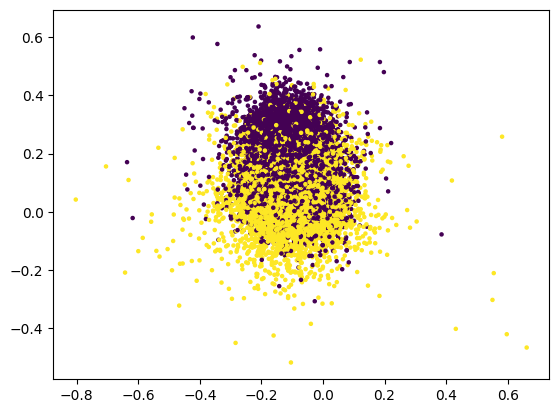

In [96]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=42).fit(X=tweets_flair_glove_embeddings)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]
plt.scatter(tweets_flair_glove_embeddings[:,0], tweets_flair_glove_embeddings[:,1], c=model.labels_, cmap='viridis', s=5, )

In [97]:
labels = model.predict(tweets_flair_glove_embeddings_df)
labels

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [98]:
tweets_sentiment_df['sentiment_flair_glove_embed_kmeans'] = labels
tweets_sentiment_df.replace({'sentiment_flair_glove_embed_kmeans': {0: -1}}, inplace=True)
print(tweets_sentiment_df.sentiment_flair_glove_embed_kmeans.value_counts())
tweets_sentiment_df.head()


sentiment_flair_glove_embed_kmeans
-1    10980
 1     7166
Name: count, dtype: int64


,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk,sentiment_flair_glove_embed_kmeans
0,0,it is very bad thing to say that government di...,Mumbai,2022,"[it, is, very, bad, thing, to, say, that, gove...",-1,-1,-1
1,1,all netas and their family should be admitted ...,Mumbai,2022,"[all, netas, and, their, family, should, be, a...",-1,-1,-1
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022,"[govandi, is, one, of, the, hotspot, of, a, we...",1,-1,1
3,3,till when medical negligence will exist in gov...,Mumbai,2022,"[till, when, medical, negligence, will, exist,...",-1,-1,-1
4,4,me being a doctor reading this also government...,Mumbai,2022,"[me, being, a, doctor, reading, this, also, go...",1,-1,-1


# Document Embeddings (Forward and Backward Embeddings being Stacked)

In [ ]:
matrix = list()

for tweets in tweets_df.tweet:
    sentence = Sentence(tweets)
    document_embeddings.embed(sentence)
    embedding = sentence.get_embedding()
    matrix.append(embedding)
    
matrix

In [100]:
def convert_to_numpy(tensor):
    tensor = tensor.numpy()  
    return tensor

tweets_flair_document_embeddings = map(convert_to_numpy, matrix)
col_names = [str(i) for i in range(0, 4096)]
tweets_flair_document_embeddings_df = pd.DataFrame(data=tweets_flair_document_embeddings)

tweets_flair_document_embeddings = tweets_flair_document_embeddings_df.values
print(tweets_flair_document_embeddings.shape)
tweets_flair_document_embeddings

(18146, 4096)


array([[-4.1331509e-03, -1.0000378e-01, -1.3477282e-03, ...,
         1.1222728e-02, -2.6670995e-04,  3.7192742e-03],
       [-3.9819814e-03, -2.5868593e-04, -1.6675468e-03, ...,
         1.1032482e-02,  9.6435389e-05,  1.6406050e-04],
       [-6.2555885e-03, -2.6860505e-02, -1.9966967e-03, ...,
         1.3707035e-02,  1.0087871e-03,  8.7704035e-03],
       ...,
       [-3.2301471e-03, -1.0388168e-01, -2.0250957e-03, ...,
         9.6313311e-03, -3.7437107e-04,  1.8388622e-03],
       [-2.8031054e-03,  6.7952336e-03, -2.6321071e-03, ...,
         7.0746979e-03,  1.1414181e-04,  3.7251799e-03],
       [-3.5365426e-03, -4.1895758e-02, -4.6253967e-04, ...,
         1.4520946e-02,  4.0051356e-04,  4.7580153e-03]], dtype=float32)

## KMeans Clustering for Sentiment Analysis using Document Embeddings 

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


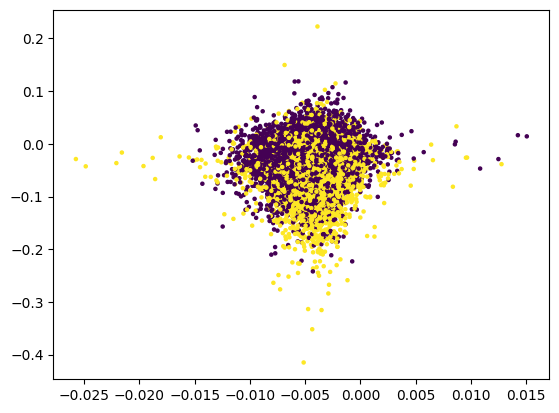

In [101]:
model_document = KMeans(n_clusters=2, max_iter=1000, random_state=42).fit(X=tweets_flair_document_embeddings)
positive_cluster_center_document = model_document.cluster_centers_[0]
negative_cluster_center_document = model_document.cluster_centers_[1]
plt.scatter(tweets_flair_document_embeddings[:,0], tweets_flair_document_embeddings[:,1], c=model.labels_, cmap='viridis', s=5)

In [102]:
labels = model_document.predict(tweets_flair_document_embeddings_df)
labels

array([1, 1, 0, ..., 1, 0, 1], dtype=int32)

In [103]:
tweets_sentiment_df['sentiment_flair_document_embed_kmeans'] = labels
tweets_sentiment_df.replace({'sentiment_flair_document_embed_kmeans': {1: -1}}, inplace=True)
tweets_sentiment_df.replace({'sentiment_flair_document_embed_kmeans': {0: 1}}, inplace=True)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk,sentiment_flair_glove_embed_kmeans,sentiment_flair_document_embed_kmeans
0,0,it is very bad thing to say that government di...,Mumbai,2022,"[it, is, very, bad, thing, to, say, that, gove...",-1,-1,-1,-1
1,1,all netas and their family should be admitted ...,Mumbai,2022,"[all, netas, and, their, family, should, be, a...",-1,-1,-1,-1
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022,"[govandi, is, one, of, the, hotspot, of, a, we...",1,-1,1,1
3,3,till when medical negligence will exist in gov...,Mumbai,2022,"[till, when, medical, negligence, will, exist,...",-1,-1,-1,-1
4,4,me being a doctor reading this also government...,Mumbai,2022,"[me, being, a, doctor, reading, this, also, go...",1,-1,-1,1


# FastText Embeddings

In [59]:
embedding_size = 300
window_size = 5
min_word = 5
down_sampling = 1e-2

fast_text_model = FastText(tweets_df.tweets_tokens.tolist(),
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1)

In [62]:
fast_text_model.save("/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/embeddings/fastext/ft_model_tweets")
fast_text_model = Word2Vec.load("/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/embeddings/fastext/ft_model_tweets")


In [70]:
print(fast_text_model.wv['negligence'].shape)
print(fast_text_model.wv.most_similar('negligence', topn=10))

(100,)
[('negligent', 0.9519049525260925), ('intelligence', 0.918562114238739), ('absence', 0.8175166249275208), ('negligible', 0.8164893984794617), ('audience', 0.8008370995521545), ('influence', 0.8002687096595764), ('silence', 0.7995046973228455), ('defence', 0.7815203070640564), ('licence', 0.7688952684402466), ('sentence', 0.768765389919281)]


In [71]:
def create_file(create_file, model_file, x):
    fast_text_model = Word2Vec.load(model_file)
    
    with open(create_file, 'w+') as word2vec_file:
        for index, row in x.iterrows():
            model_vector = (np.mean([fast_text_model.wv[token] for token in row['tweets_tokens']], axis=0)).tolist()
            if index == 0:
                header = ",".join(str(ele) for ele in range(100))
                word2vec_file.write(header)
                word2vec_file.write("\n")
            
            if type(model_vector) is list:
                line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
            else:
                line1 = ",".join([str(0) for i in range(100)])
            word2vec_file.write(line1)
            word2vec_file.write('\n')
    
    df = pd.read_csv(create_file)
    return df
        

In [104]:
fast_text_filename = '/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/embeddings/fast_text/fast_text_tweets_embeddings.csv'
fast_text_model_file = '/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/embeddings/fast_text/ft_model_tweets'
fast_text_tweets_embeddings_df = create_file(fast_text_filename, fast_text_model_file, tweets_df)

fast_text_tweets_embeddings = fast_text_tweets_embeddings_df.values

print(fast_text_tweets_embeddings_df.shape)
fast_text_tweets_embeddings_df.head()

(18146, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.006640,0.010716,-0.016807,-0.232384,0.318515,0.053178,0.170977,0.362389,0.035218,0.009109,...,0.139264,0.097142,0.150459,-0.125072,0.239983,0.045312,-0.035978,-0.195632,0.019838,-0.115196
1,-0.013340,-0.069697,-0.050883,-0.197892,0.300944,0.095729,0.127337,0.412918,0.038286,0.051453,...,0.068533,0.183935,0.090299,-0.180700,0.231895,-0.021995,-0.024444,-0.129946,0.129721,-0.047438
2,0.047252,0.041129,-0.055585,-0.255178,0.286711,0.031385,0.124224,0.435812,0.001590,-0.023983,...,0.104677,0.122234,0.120467,-0.156586,0.244549,0.096828,-0.073133,-0.261720,0.105407,-0.109612
3,-0.025087,0.113630,-0.055398,-0.241255,0.267088,-0.000640,0.155886,0.386457,0.122789,0.065896,...,0.103561,0.155421,0.157816,-0.164538,0.205770,0.064101,-0.022347,-0.159225,0.108928,-0.101878
4,-0.079483,0.037777,0.038310,-0.225262,0.353705,0.044114,0.128894,0.306316,0.079160,0.018944,...,0.213182,0.066088,0.061178,-0.245022,0.313848,-0.052966,-0.167514,0.015939,0.066961,-0.019265


## KMeans Clustering for Sentiment Analysis using FastText Embeddings

/Users/nitanshjain/.local/share/virtualenvs/Twitter_Data_Analysis-wZ120kVj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


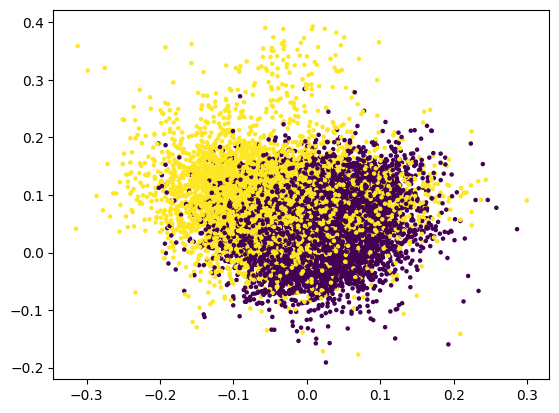

In [105]:
model_fast_text = KMeans(n_clusters=2, max_iter=1000, random_state=42).fit(X=fast_text_tweets_embeddings_df)
positive_cluster_center_document = model_fast_text.cluster_centers_[0]
negative_cluster_center_document = model_fast_text.cluster_centers_[1]
plt.scatter(fast_text_tweets_embeddings[:,0], fast_text_tweets_embeddings[:,1], c=model.labels_, cmap='viridis', s=5)

In [106]:
labels = model_fast_text.predict(fast_text_tweets_embeddings_df)
labels

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

In [113]:
tweets_sentiment_df['sentiment_fast_text_embed_kmeans'] = labels
tweets_sentiment_df.replace({'sentiment_fast_text_embed_kmeans': {0: -1}}, inplace=True)
tweets_sentiment_df.replace({'sentiment_fast_text_embed_kmeans': {1: 1}}, inplace=True)
tweets_sentiment_df.head()

,tweet_id,tweet,city,year,tweets_tokens,sentiment_flair,sentiment_nltk,sentiment_flair_glove_embed_kmeans,sentiment_flair_document_embed_kmeans,sentiment_fast_text_embed_kmeans
0,0,it is very bad thing to say that government di...,Mumbai,2022,"[it, is, very, bad, thing, to, say, that, gove...",-1,-1,-1,-1,-1
1,1,all netas and their family should be admitted ...,Mumbai,2022,"[all, netas, and, their, family, should, be, a...",-1,-1,-1,-1,-1
2,2,govandi is one of the hotspot of a well other ...,Mumbai,2022,"[govandi, is, one, of, the, hotspot, of, a, we...",1,-1,1,1,-1
3,3,till when medical negligence will exist in gov...,Mumbai,2022,"[till, when, medical, negligence, will, exist,...",-1,-1,-1,-1,-1
4,4,me being a doctor reading this also government...,Mumbai,2022,"[me, being, a, doctor, reading, this, also, go...",1,-1,-1,1,-1


# Value Counts

In [117]:
print(tweets_sentiment_df.sentiment_flair.value_counts())
print(tweets_sentiment_df.sentiment_nltk.value_counts())
print(tweets_sentiment_df.sentiment_flair_glove_embed_kmeans.value_counts())
print(tweets_sentiment_df.sentiment_flair_document_embed_kmeans.value_counts())
print(tweets_sentiment_df.sentiment_fast_text_embed_kmeans.value_counts())


sentiment_flair
-1    10407
 1     7739
Name: count, dtype: int64
sentiment_nltk
-1    10182
 1     7964
Name: count, dtype: int64
sentiment_flair_glove_embed_kmeans
-1    10980
 1     7166
Name: count, dtype: int64
sentiment_flair_document_embed_kmeans
-1    11828
 1     6318
Name: count, dtype: int64
sentiment_fast_text_embed_kmeans
-1    10222
 1     7924
Name: count, dtype: int64


In [85]:
tweets_df = pd.read_csv('/Users/nitanshjain/Documents/Projects/Twitter_Data_Analysis/v2/data/tweets_with_sentiment_v2.csv')